## Face blurring

Isthmus / Mitchellpkt

Automatically detects faces in images and filters them. 

Modes include:
-  Box: Draws non-filled rectangle around face (debugging mode, no privacy)
-  Blur: Applies a Gaussian Blur filter over the face, kernel size adjustable in settings
-  Block: Draws filled rectangle over face (most privacy)

Leveraging some code from a [face detection guide](https://realpython.com/traditional-face-detection-python/) and stackoverflow thread about [blurring faces](https://stackoverflow.com/questions/18064914/how-to-use-opencv-python-to-blur-faces).

## Install libraries

In [1]:
#!pip install opencv-python
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os

## Settings

In [2]:
# Variable
path_to_image = os.path.join('inputs','images', 'testfilehalf.png')
privacy_mode = 'blur' # options: blur block box

# Blur settings
blur_intensity = 23 # kernel width for Gaussian blur
highlight_edges = 0 # Draw boxes before blurring? [0 / 1]

In [3]:
# Static
path_to_model = os.path.join('inputs','models','haarcascade_frontalface_alt.xml')

## Define some functions

In [4]:
def pop_image(image):
    cv.imshow('Image', image)
    cv.waitKey(0)
    cv.destroyAllWindows()

## Import image

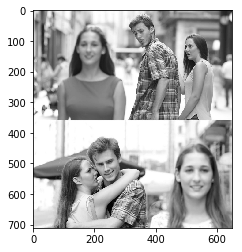

In [5]:
# Read image from your local file system
original_image = cv.imread(path_to_image)
#plt.imshow(original_image)

# Convert color image to grayscale for Viola-Jones
grayscale_image = cv.cvtColor(original_image, cv.COLOR_BGR2GRAY)
plt.imshow(grayscale_image, cmap='gray')

## Load and query classifier

In [6]:
# Load the classifier and create a cascade object for face detection
face_cascade = cv.CascadeClassifier(path_to_model)

In [7]:
detected_faces = face_cascade.detectMultiScale(grayscale_image)

## Filter the image

In [8]:
filtered_image = original_image

if privacy_mode == 'box':
    for (column, row, width, height) in []:#detected_faces:
        cv.rectangle(
            filtered_image,
            (column, row),
            (column + width, row + height),
            (255, 0, 0),
            2
        )
        
if privacy_mode == 'block':
    for (column, row, width, height) in detected_faces:
        cv.rectangle(
            filtered_image,
            (column, row),
            (column + width, row + height),
            (255, 255, 0),
            -1,
        )

if privacy_mode == 'blur':        
    blur_intensity_odd = int(np.floor(blur_intensity/2)*2+1)
    for f in detected_faces:         # For each face in the image
        # Get the origin co-ordinates and the length and width till where the face extends
        x, y, w, h = [ v for v in f ]

        # get the rectangle img around all the faces
        if highlight_edges == 1:
            cv.rectangle(filtered_image, (x,y), (x+w,y+h), (255,255,0), 5)
        sub_face = filtered_image[y:y+h, x:x+w]
        # apply a gaussian blur on this new recangle image
        sub_face = cv.GaussianBlur(sub_face,(blur_intensity_odd, blur_intensity_odd), 30)
        # merge this blurry rectangle to our final image
        filtered_image[y:y+sub_face.shape[0], x:x+sub_face.shape[1]] = sub_face



## Show results

Show inline (buggy colors)

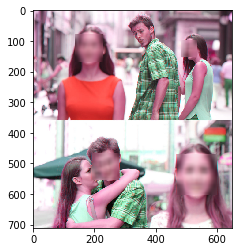

In [9]:
fig = plt.figure
plt.imshow(np.roll(filtered_image,-2))

Popout image (click into & press any key to close)

In [10]:
pop_image(filtered_image)

Save image

In [11]:
face_file_name = "./face_" + str(y) + ".jpg"
#cv.imwrite(face_file_name, sub_face)